In [67]:
#importing the necessary Libraries

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [97]:
#Loading the dataset

In [98]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

In [99]:
df=pd.read_excel("Telco_customer_churn.xlsx")

In [100]:
#viewing first 5 rows 

In [101]:
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


In [102]:
#reformatting the columns as per convinience

In [103]:
df.columns=df.columns.str.lower().str.replace(" ", "_")

In [104]:
#dropping unnecessary columns
#dropping churn label because churn label and churn value are same columns with different
# representaiton

In [105]:
df.drop(columns=['customerid','count','city','zip_code','lat_long','latitude','longitude','churn_label', 'country','state'], inplace=True)

In [106]:
#find the shape of dataset
df.shape

(7043, 23)

In [107]:
#checking for null values
#found 5174 null values on churn_reason. 
#Donot think of these as null values, these are null because customers stayed,
# so the churn_reason is null

In [108]:
df.isnull().sum()

gender                  0
senior_citizen          0
partner                 0
dependents              0
tenure_months           0
phone_service           0
multiple_lines          0
internet_service        0
online_security         0
online_backup           0
device_protection       0
tech_support            0
streaming_tv            0
streaming_movies        0
contract                0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
churn_value             0
churn_score             0
cltv                    0
churn_reason         5174
dtype: int64

In [109]:
#checking for duplicates on entire dataset

In [110]:
dup = df.duplicated().sum()
print(dup," duplicates found in dataset")

0  duplicates found in dataset


In [111]:
#performing value_counts to understand values in each column of dataset

In [112]:
for col in df.columns:
    print(f"\n Value Counts for columns: {col}")
    print(df[col].value_counts(normalize=True, dropna=False))


 Value Counts for columns: gender
gender
Male      0.504756
Female    0.495244
Name: proportion, dtype: float64

 Value Counts for columns: senior_citizen
senior_citizen
No     0.837853
Yes    0.162147
Name: proportion, dtype: float64

 Value Counts for columns: partner
partner
No     0.516967
Yes    0.483033
Name: proportion, dtype: float64

 Value Counts for columns: dependents
dependents
No     0.76899
Yes    0.23101
Name: proportion, dtype: float64

 Value Counts for columns: tenure_months
tenure_months
1     0.087037
72    0.051399
2     0.033792
3     0.028397
4     0.024989
        ...   
28    0.008093
39    0.007951
44    0.007241
36    0.007099
0     0.001562
Name: proportion, Length: 73, dtype: float64

 Value Counts for columns: phone_service
phone_service
Yes    0.903166
No     0.096834
Name: proportion, dtype: float64

 Value Counts for columns: multiple_lines
multiple_lines
No                  0.481329
Yes                 0.421837
No phone service    0.096834
Name: prop

In [113]:
# transforming columns accordingly

In [114]:
yncol=['multiple_lines','online_security','online_backup','device_protection','tech_support',
       'streaming_tv', 'streaming_movies','paperless_billing']

for c in yncol:
   df[c].replace({'No internet service': 'No', 'No phone service':'No'}, inplace=True)

In [115]:
#replacing the null values in churn_reason to "Stayed"

In [116]:
df['churn_reason'].replace(np.nan, "Stayed", inplace=True)

In [117]:
#mapping churn_reason into categories Customer Care, Product, Price, Moved, Stayed

In [118]:
crdict={'Attitude of support person' : 'Customer Care',
                  'Attitude of service provider' : 'Customer Care', 
                  'Service dissatisfaction' : 'Customer Care', 
                  'Lack of self-service on Website' : 'Customer Care', 
                  'Poor expertise of phone support'  : 'Customer Care', 
                  'Poor expertise of online support' : 'Customer Care', 
                  'Competitor offered higher download speeds' : 'Product', 
                  'Competitor offered more data' : 'Product', 
                  'Competitor had better devices' : 'Product', 
                  'Network reliability' : 'Product', 
                  'Product dissatisfaction' : 'Product', 
                  'Limited range of services' : 'Product', 
                  'Competitor made better offer' : 'Price', 
                  'Price too high' : 'Price', 
                  'Extra data charges' : 'Price', 
                  'Long distance charges' : 'Price', 
                  'Lack of affordable download/upload speed' : 'Product', 
                  'Moved' : 'Moved', 
                  'Deceased' : 'Moved',
                  "Don't know" : 'Unknown',
                  'Stayed':'Stayed'
       }
df['churn_group']=df['churn_reason'].map(crdict)

In [120]:
#checking datatype of each column,
#monthly charges has to be numeric but is in "object" type

In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             7043 non-null   object 
 1   senior_citizen     7043 non-null   object 
 2   partner            7043 non-null   object 
 3   dependents         7043 non-null   object 
 4   tenure_months      7043 non-null   int64  
 5   phone_service      7043 non-null   object 
 6   multiple_lines     7043 non-null   object 
 7   internet_service   7043 non-null   object 
 8   online_security    7043 non-null   object 
 9   online_backup      7043 non-null   object 
 10  device_protection  7043 non-null   object 
 11  tech_support       7043 non-null   object 
 12  streaming_tv       7043 non-null   object 
 13  streaming_movies   7043 non-null   object 
 14  contract           7043 non-null   object 
 15  paperless_billing  7043 non-null   object 
 16  payment_method     7043 

In [122]:
#checking for rows which are not numeric
#some rows have " " as total_charges

In [123]:
df[df['total_charges'].astype(str).str.contains(r'[^0-9.]', na=False)]

,gender,senior_citizen,partner,dependents,tenure_months,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn_value,churn_score,cltv,churn_reason,churn_group
2234,Female,No,Yes,No,0,No,No,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,0,36,2578,Stayed,Stayed
2438,Male,No,No,No,0,Yes,No,No,No,No,No,No,No,No,Two year,No,Mailed check,20.25,,0,68,5504,Stayed,Stayed
2568,Female,No,Yes,No,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,0,45,2048,Stayed,Stayed
2667,Male,No,Yes,Yes,0,Yes,Yes,No,No,No,No,No,No,No,Two year,No,Mailed check,25.75,,0,48,4950,Stayed,Stayed
2856,Female,No,Yes,No,0,No,No,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,0,30,4740,Stayed,Stayed
4331,Male,No,Yes,Yes,0,Yes,No,No,No,No,No,No,No,No,Two year,No,Mailed check,19.85,,0,53,2019,Stayed,Stayed
4687,Male,No,Yes,Yes,0,Yes,Yes,No,No,No,No,No,No,No,Two year,No,Mailed check,25.35,,0,49,2299,Stayed,Stayed
5104,Female,No,Yes,Yes,0,Yes,No,No,No,No,No,No,No,No,Two year,No,Mailed check,20.00,,0,27,3763,Stayed,Stayed
5719,Male,No,Yes,Yes,0,Yes,No,No,No,No,No,No,No,No,One year,Yes,Mailed check,19.70,,0,69,4890,Stayed,Stayed
6772,Female,No,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,0,44,2342,Stayed,Stayed


In [ ]:
#filling those values of total_charges by using tenure_months and monthly_charges columns 

In [124]:
indx=[2234, 2438, 2568, 2667, 2856, 4331, 4687, 5104, 6772, 6840]
df.loc[indx,'tenure_months']=24
df.loc[5719,'tenure_months']=12
indx1=[2234, 2438, 2568, 2667, 2856, 4331, 4687, 5104, 5719, 6772, 6840]
df.loc[indx,'total_charges']=df['tenure_months']*df['monthly_charges']
df.loc[5719,'total_charges']=236.4

In [125]:
df['been_since']=df['tenure_months']/12
df['been_since']=df['been_since'].round(2)

In [ ]:
#modifying payment method into a column which has only 2 categorical values

In [126]:
pay_map={'Electronic check':'Online',
         'Bank transfer (automatic)':'Online',
         'Credit card (automatic)':'Online',
         'Mailed check':'Offline'
        }
df['payment_mode']=df['payment_method'].map(pay_map)

In [ ]:
#onehotencoding categorical values

In [128]:
df1=pd.get_dummies(data=df,columns=['gender','senior_citizen','partner','dependents', 'phone_service', 'multiple_lines',
            'internet_service','online_security','online_backup','device_protection', 'tech_support','paperless_billing',
            'streaming_tv', 'streaming_movies', 'contract', 'payment_mode','churn_group'], drop_first=True, dtype=int)

In [129]:
drop_col=['payment_method','churn_reason']
df1.drop(columns=drop_col, inplace=True)

In [130]:
df1.columns=df1.columns.str.lower().str.replace(" ","_")

In [131]:
df1['total_charges']=df1['total_charges'].astype('float')

In [ ]:
#creating a new column which indicates the total number of services used by a customer

In [132]:
df1['no_services']=df1.loc[:,'internet_service_fiber_optic':'streaming_movies_yes'].sum(axis=1)

In [ ]:
# show heatmap for correlation matrix

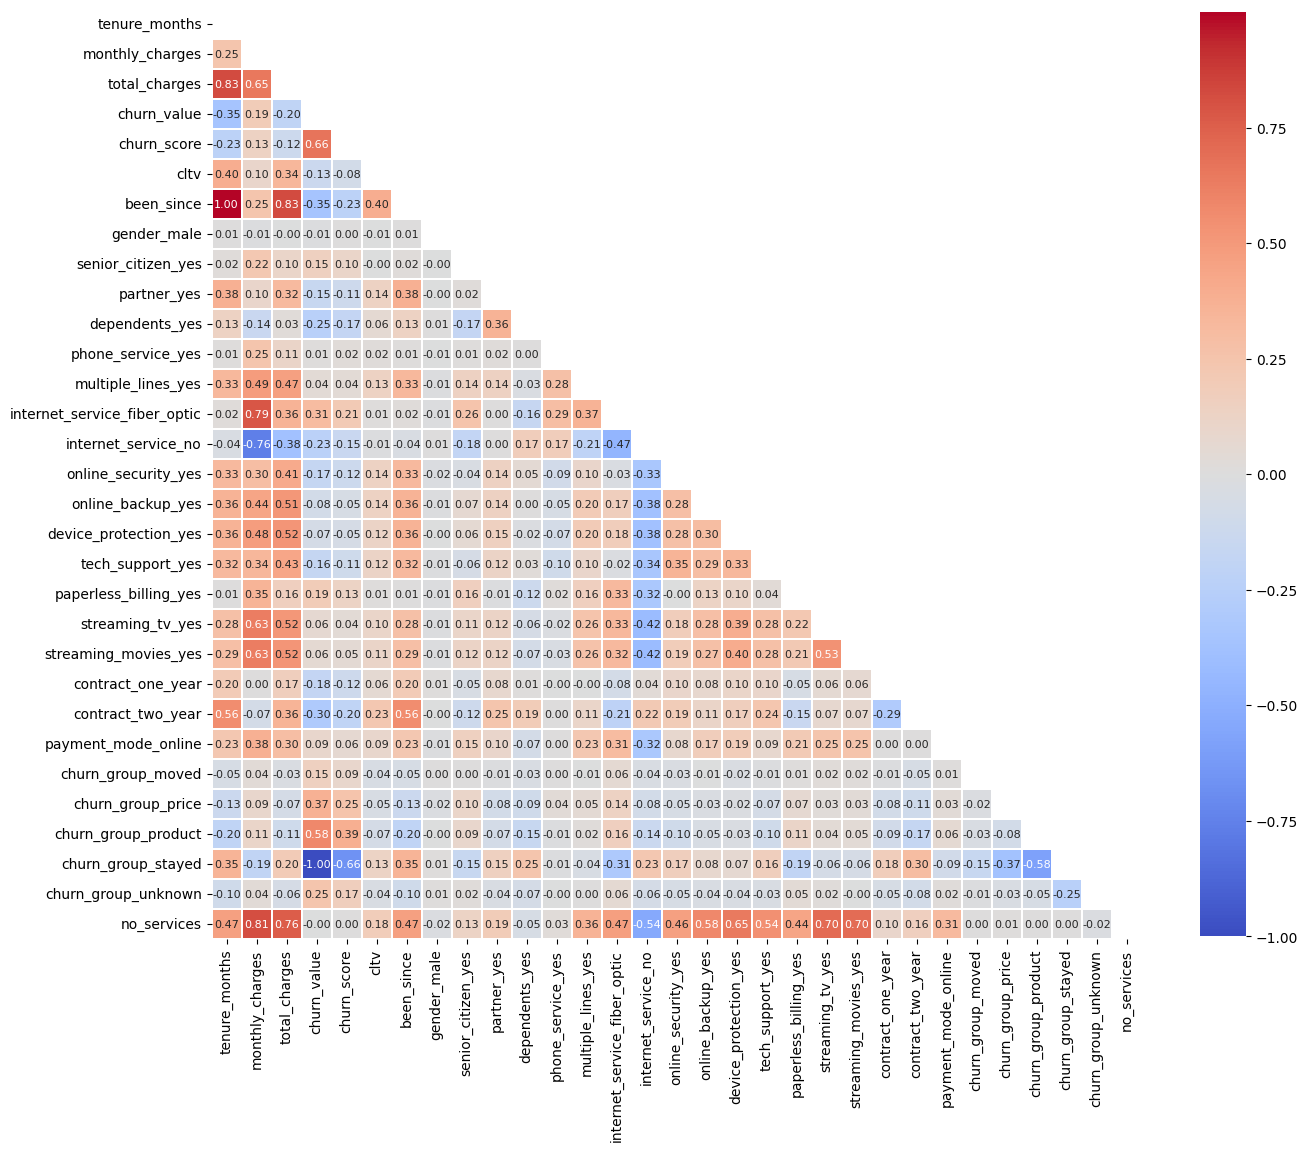

In [133]:
f, ax = plt.subplots(figsize=(15,15))
mask = np.zeros(df1.corr().shape, dtype=bool)
mask[np.triu_indices(len(mask))] = True
sns.heatmap(df1.corr(), mask = mask, fmt='.2f',
            center=0, linewidths=0.3, cmap='coolwarm', square=True, 
            annot=True, cbar_kws={'shrink': 0.8}, annot_kws={'size': 8})
plt.tight_layout
plt.show()

In [ ]:
#analysing the correlation between the variables to remove highly correlated variables
#to reduce redundancy

In [134]:
 def redundant_pairs(df):
    drop_pairs=set()
    cols=df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            drop_pairs.add((cols[i], cols[j]))
    return drop_pairs
def top_abs_corr(df, n=5):
    au_corr=df.corr().abs().unstack()
    drop_labels=redundant_pairs(df)
    au_corr=au_corr.drop(labels=drop_labels).sort_values(ascending=False)
    return au_corr[0:n]


In [135]:
print(top_abs_corr(df1,20))

churn_value            churn_group_stayed              1.000000
tenure_months          been_since                      0.999999
                       total_charges                   0.825887
total_charges          been_since                      0.825878
monthly_charges        no_services                     0.813417
                       internet_service_fiber_optic    0.787066
                       internet_service_no             0.763557
total_charges          no_services                     0.758011
streaming_tv_yes       no_services                     0.703833
streaming_movies_yes   no_services                     0.702461
churn_value            churn_score                     0.664897
churn_score            churn_group_stayed              0.664897
monthly_charges        total_charges                   0.651262
device_protection_yes  no_services                     0.646773
monthly_charges        streaming_tv_yes                0.629603
                       streaming_movies_

In [136]:
df1.drop(columns=['churn_group_stayed','no_services','been_since', 'total_charges'], inplace=True)

In [137]:
print(top_abs_corr(df1,20))

monthly_charges               internet_service_fiber_optic    0.787066
                              internet_service_no             0.763557
churn_value                   churn_score                     0.664897
monthly_charges               streaming_tv_yes                0.629603
                              streaming_movies_yes            0.627429
churn_value                   churn_group_product             0.584628
tenure_months                 contract_two_year               0.561648
streaming_tv_yes              streaming_movies_yes            0.533094
monthly_charges               multiple_lines_yes              0.490434
                              device_protection_yes           0.482692
internet_service_fiber_optic  internet_service_no             0.465793
monthly_charges               online_backup_yes               0.441780
internet_service_no           streaming_movies_yes            0.418675
                              streaming_tv_yes                0.415552
device

In [138]:
y = df1['churn_value']
X = df1.drop(columns=['churn_value'], axis=1)

In [ ]:
#Performing train test and validation split
#Train data is 70% of total data
#validation data is 20% of total data
#Test data is 10% of total data(Treated as new data, 
#usually used to test the predictions of the model on new data

In [139]:
X_train, X1, y_train, y1=train_test_split(X, y, stratify = y, test_size=0.3, random_state=40)
X_val, X_test, y_val, y_test= train_test_split(X1, y1, stratify = y1, test_size=0.33,random_state=40)

In [ ]:
#Perfroming Scaling to bring all features into same scale, so model learns better

In [140]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val=scaler.transform(X_val)
X_test=scaler.transform(X_test)


In [ ]:
#we are going to check for the performance of the following classification algorithms

In [141]:
initial_models = {
        "Logistic Regression": LogisticRegression(),
        "Random Forest": RandomForestClassifier(),
        "Suppost Vector Classifier":SVC(),
        "Decision Tree Classifier":DecisionTreeClassifier(),
        "XGBoost": XGBClassifier()
    }
    

In [ ]:
#Creating a funtion to evaluate the results of models and storing them in a dictionary
#this disctionary is converted into DF, so it is easy to compare and appears clean

In [142]:
def evaluating(X_train, X_test, y_train, y_test, models):
    results = []
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_vpred = model.predict(X_test)  
        accuracy = accuracy_score(y_test, y_vpred) 
        precision = precision_score(y_test, y_vpred)
        recall = recall_score(y_test, y_vpred)
        f1 = f1_score(y_test, y_vpred)
        roc_auc = roc_auc_score(y_test, y_vpred)
        results.append({
            "Model Name": model_name,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1-score": f1,
            "ROC AUC": roc_auc
        })
    return results

In [ ]:
#Training the model and testing it on validation dataset

In [144]:
validation_metrics=pd.DataFrame(evaluating(X_train,X_val,y_train, y_val, initial_models))
validation_metrics

,Model Name,Accuracy,Precision,Recall,F1-score,ROC AUC
0,Logistic Regression,0.972438,0.966759,0.928191,0.947083,0.958321
1,Random Forest,0.973145,0.964286,0.933511,0.948649,0.960499
2,Suppost Vector Classifier,0.970318,0.977143,0.909574,0.942149,0.950937
3,Decision Tree Classifier,0.964664,0.928947,0.938830,0.933862,0.956422
4,XGBoost,0.972438,0.964187,0.930851,0.947226,0.959170


In [ ]:
# Perform cross-validation and evaluate models to make it robust
# rebostness is performing better with unseen data

In [146]:
results = []
for model_name, model in initial_models.items():
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=40)
    cv_scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    results.append({
        "Model Name":model_name,
        "Mean Accuracy":cv_scores.mean(), 
        "Standard Deviation":cv_scores.std()
    })
    

kfold_evaluation=pd.DataFrame(results)
kfold_evaluation

,Model Name,Mean Accuracy,Standard Deviation
0,Logistic Regression,0.960243,0.004369
1,Random Forest,0.966531,0.003740
2,Suppost Vector Classifier,0.952130,0.004643
3,Decision Tree Classifier,0.954158,0.003816
4,XGBoost,0.964909,0.002613


In [ ]:
# RandomForest and XGBClassifier have been picked and evaluated on Test data


In [147]:
final_models = {
        "Random Forest": RandomForestClassifier(),
        "XGBoost": XGBClassifier()
    }
    
final_scores=pd.DataFrame(evaluating(X_train, X_test, y_train, y_test, final_models))
final_scores

,Model Name,Accuracy,Precision,Recall,F1-score,ROC AUC
0,Random Forest,0.961318,0.964706,0.886486,0.923944,0.937395
1,XGBoost,0.954155,0.932203,0.891892,0.911602,0.934250
